##Download data
I used the New York metadata from the Google Local Data (2021) dataset (see https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal/metaNew_York.json.gz)


In [ ]:
#downloading data from link
import urllib.request
filename = 'meta-New_York.json.gz'
urllib.request.urlretrieve('https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal/meta-New_York.json.gz', filename)

('meta-New_York.json.gz', <http.client.HTTPMessage at 0x7878e9f23610>)

In [ ]:
#installing required packages
!pip install ijson

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.8/111.8 kB 2.5 MB/s eta 0:00:00


In [ ]:
#extract tags from original json file
#This filters out data not needed in the project
import json, ijson, gzip
import numpy as np

def parse(path):
  """function to parse gzipped JSON lines from file"""
  with gzip.open(path, 'rt', encoding='utf-8') as g:
    for line in g:
      yield json.loads(line)

def convert_to_jsonl(gz_filename, output_filename):
  """function to extract relevant information and put it into a .jsonl file"""
  with open(output_filename, 'w') as output_file:
    for obj in parse(gz_filename):
      rating = {}
      if 'avg_rating' in obj:
          rating['rating'] = obj['avg_rating']
      if 'category' in obj:
          rating['category'] = obj['category']
      if 'latitude' in obj:
          rating['latitude'] = obj['latitude']
          rating['latitude_0dp'] = round(obj['latitude'])
      if 'longitude' in obj:
          rating['longitude'] = obj['longitude']
          rating['longitude_0dp'] = round(obj['longitude'])

      if len(rating) == 6:
          output_file.write(json.dumps(rating) + '\n')

# Specify the output JSON Lines file name
output_filename = 'meta-New_York.jsonl'
convert_to_jsonl(filename, output_filename)

In [ ]:
#shows a sample of the first and last 10 extracted reviews
!head -10 'meta-New_York.jsonl'
!tail -10 'meta-New_York.jsonl'

{"rating": 2, "category": ["Insurance broker", "Insurance agency"], "latitude": 40.5782537, "latitude_0dp": 41, "longitude": -73.9591269, "longitude_0dp": -74}
{"rating": 3.5, "category": ["Cell phone store", "Electronic parts supplier", "Electronics store", "Telecommunications service provider", "Telephone company"], "latitude": 40.750146099999995, "latitude_0dp": 41, "longitude": -73.8625356, "longitude_0dp": -74}
{"rating": 3.4, "category": ["Hardware store", "Building materials store", "Electrical supply store", "Home improvement store", "Plumbing supply store"], "latitude": 40.7331818, "latitude_0dp": 41, "longitude": -73.9902006, "longitude_0dp": -74}
{"rating": 3, "category": ["Corporate office"], "latitude": 43.054743099999996, "latitude_0dp": 43, "longitude": -77.6491365, "longitude_0dp": -78}
{"rating": 5, "category": ["Peninsula"], "latitude": 42.7156261, "latitude_0dp": 43, "longitude": -76.7102269, "longitude_0dp": -77}
{"rating": 4.7, "category": ["Diner"], "latitude": 42

## Loading the data into a Dask Bag + Dask Dataframe

---


See https://docs.dask.org/en/latest/generated/dask.dataframe.read_json.html

In [ ]:
#loading data in a dask bag
import dask
from dask import dataframe as dff
from dask import bag as db

data_bag = db.read_text('meta-New_York.jsonl', blocksize="1MB")
print(data_bag)

dask.bag<bag-from-delayed, npartitions=45>


In [ ]:
#create a dataframe from json data
import re
import json


def process_line(line):
  """ensuring all entries are in the correct dtype"""
  entry = json.loads(line)
  results = []
  rating = float(entry['rating'])
  longitude = float(entry['longitude'])
  latitude = float(entry['latitude'])
  longitude_0dp = float(entry['longitude_0dp'])
  latitude_0dp = float(entry['latitude_0dp'])
  category = entry['category']
  #potentially could try to seperate out category here, and have duplicates with other values
  results.append((rating, category, latitude, latitude_0dp, longitude, longitude_0dp))
  return results

#create a dataframe of data from databag
data_bag_for_dataframe = data_bag.map(process_line).flatten()
df = data_bag_for_dataframe.to_dataframe(columns=["rating", "category", "latitude", "latitude_0dp", "longitude", "longitude_0dp"])
print(df)


Dask DataFrame Structure:
                 rating category latitude latitude_0dp longitude longitude_0dp
npartitions=45                                                                
                float64   string  float64      float64   float64       float64
                    ...      ...      ...          ...       ...           ...
...                 ...      ...      ...          ...       ...           ...
                    ...      ...      ...          ...       ...           ...
                    ...      ...      ...          ...       ...           ...
Dask Name: to_pyarrow_string, 2 graph layers


In [ ]:
#show that dataframe contains information in the correct columns
df.head(5)

,rating,category,latitude,latitude_0dp,longitude,longitude_0dp
0,2.0,"['Insurance broker', 'Insurance agency']",40.578254,41.0,-73.959127,-74.0
1,3.5,"['Cell phone store', 'Electronic parts supplie...",40.750146,41.0,-73.862536,-74.0
2,3.4,"['Hardware store', 'Building materials store',...",40.733182,41.0,-73.990201,-74.0
3,3.0,['Corporate office'],43.054743,43.0,-77.649136,-78.0
4,5.0,['Peninsula'],42.715626,43.0,-76.710227,-77.0


In [ ]:
#get dataframe of smaller sizes for testing and to check scalibility
df_subset = df.tail(10);
print(df_subset.columns.tolist())

['rating', 'category', 'latitude', 'latitude_0dp', 'longitude', 'longitude_0dp']


#Algorithms for Analysis

In [ ]:
import math
def calculate_distance(point1_lat, point1_lng, point2_lat, point2_lng):
    """distance between 2 points (with lat and lng) is calculated using the haversine function
    from https://www.geeksforgeeks.org/haversine-formula-to-find-distance-between-two-points-on-a-sphere/
    from https://www.igismap.com/haversine-formula-calculate-geographic-distance-earth/
    a = sin²(ΔlatDifference/2) + cos(lat1).cos(lt2).sin²(ΔlonDifference/2)
    c = 2.asin(√a)
    d = R.c
    where ΔlatDifference = lat1 – lat2 (difference of latitude)
    ΔlonDifference = lon1 – lon2 (difference of longitude)
    R is radius of earth i.e 6371 KM
    d is the distance computed between two points."""
    diff_lat = (point2_lat - point1_lat) * math.pi / 180.0
    diff_lng = (point2_lng - point1_lng) * math.pi / 180.0

    # convert to radians
    point1_lat *= (math.pi / 180.0)
    point2_lat *= (math.pi / 180.0)

    # apply haversine formulae
    a = (pow(math.sin(diff_lat / 2), 2) +
         pow(math.sin(diff_lng / 2), 2) *
             math.cos(point1_lat) * math.cos(point2_lat));
    #radius is in km
    RADIUS_OF_EARTH = 6371.0

    c = 2 * math.asin(math.sqrt(a))

    return RADIUS_OF_EARTH * c



# used to test if calculate distance works
print(calculate_distance(-43.52183338438556, 172.57931937823682, -43.52978150622161, 172.6372111749494))

4.750374298135623


In [ ]:
#implmenting hierarchical clustering
import math

def get_center(df_cluster):
    """return means of longitude and latitude to get center"""
    means = df_cluster.mean(numeric_only=True)
    return (means['latitude'], means['longitude'])

def get_distance(center1, center2):
    """returns distance between two points given their lat and lng"""
    return calculate_distance(center1[0], center1[1], center2[0], center2[1])

def merge_clusters(cluster_pair_with_distance):
    """merges two clusters together given a tuple of (distance, (cluster1, cluster2))
    The clusters are dataframes"""
    combined_cluster = ddf.concat([cluster_pair_with_distance[1][0], cluster_pair_with_distance[1][1]])
    return combined_cluster.compute()

def are_equal(df1, df2):
    """function to compare two pandas dataframes
    is based on code from CHAT-GPT
    is not being used"""
    return df1.equals(df2)

def filter_unique(dataframes):
    """function to identify unique pandas dataframes
    Is based on code from CHAT-GPT
    Is not being used"""
    unique_dfs = []
    for frame in dataframes:
        if not any(are_equal(frame, unique_df) for unique_df in unique_dfs):
            unique_dfs.append(frame)
    return unique_dfs

def are_equal_daskdf(df1, df2):
    """function to compare two dask dataframes"""
    return df1.eq(df2).all().all()

def filter_unique_daskdf(dataframes):
    """function to identify unique dask dataframes"""
    unique_dfs = []
    for frame in dataframes:
        if not any(are_equal_daskdf(frame, unique_df) for unique_df in unique_dfs):
            unique_dfs.append(frame)
    return unique_dfs

def matches_longitude(dataframe, longitude):
    """checkes if any point in dataframe has a matching longitude"""
    for index, row in dataframe.iterrows():
      if row['longitude'] == longitude:
        return True
    return False

def filter_by_longitude(dataframes, list_of_to_merge_longitudes):
    """check if any dataframes contain points in list_of_to_merge_longitudes and removes those"""
    unique_dfs = []
    for frame in dataframes:
        if not any([matches_longitude(frame, lng) for lng in list_of_to_merge_longitudes]):
            unique_dfs.append(frame)
    return unique_dfs

def normalize_dataframe(dataframe):
    """sorts dataframe by index"""
    return dataframe.sort_index()


def merge_iteration(clusters, MAX_DISTANCE):
    """merges clusters together if the minimum distance between any two clusters is less than the MAX_DISTANCE
    MAX_DISTANCE is how far someone can walk comfortably"""
    min_distance = math.inf

    #getting all cluster combinations (pairs) and distances between their centroids
    cluster_pairs = clusters.product(clusters)
    centers_of_clusters_in_pair = cluster_pairs.map(lambda pair: (get_center(pair[0]), get_center(pair[1]), pair))
    centers_of_clusters_in_pair = centers_of_clusters_in_pair.filter(lambda x: x[0] != x[1])
    cluster_pairs_with_distance = centers_of_clusters_in_pair.map(lambda x: (get_distance(x[0], x[1]), x[2]))

    #getting all clusters that won't be merged together
    unmerged_clusters = cluster_pairs_with_distance.filter(lambda x: x[0] >= MAX_DISTANCE)
    unmerged_clusters_first = unmerged_clusters.map(lambda x: x[1][0])
    unmerged_clusters_second = unmerged_clusters.map(lambda x: x[1][1])
    unmerged_clusters = db.concat([unmerged_clusters_first, unmerged_clusters_second])
    #making sure unmerged clusters do not have duplicates
    unique_unmerged_clusters = unmerged_clusters.foldby(lambda x: None, lambda acc, x: acc + [x], [], lambda acc, x: filter_unique(acc + x)).flatten()
    unmerged_clusters = unique_unmerged_clusters.filter(lambda x: x != None).flatten()

    #getting all clusters that will be merged together
    clusters_to_merge = cluster_pairs_with_distance.filter(lambda x: x[0] < MAX_DISTANCE)
    #making sure clusters that will be merged together are not in unmerged_clusters
    list_of_to_merge_longitudes =  clusters_to_merge.map(lambda x: x[1]).flatten().map(lambda x: x['longitude'].to_numpy()).flatten()
    unmerged_clusters =  db.from_sequence(filter_by_longitude(unmerged_clusters, list_of_to_merge_longitudes))

    #merging clusters
    merged_clusters = clusters_to_merge.map(lambda x: merge_clusters(x))

    #returning all clusters
    iteration_result = db.concat([unmerged_clusters, merged_clusters])
    iteration_result = iteration_result.map(normalize_dataframe)
    unique_result = iteration_result.foldby(lambda x: None, lambda acc, x: acc + [x], [], lambda acc, x: filter_unique_daskdf(acc + x)).flatten()
    iteration_result =  unique_result.filter(lambda x: x != None).flatten()
    return iteration_result

def apply_clustering(df_group):
    """repeatly creates clusters until we have our final set of clusters"""
    MAX_DISTANCE = 0.4
    min_distance = math.inf

    df_group.reset_index()
    df_split = [df_group.loc[[i]] for i in df_group.index if df_group.loc[[i]].size > 4]

    clusters = db.from_sequence(df_split)
    initial_count = math.inf
    # Start agglomerative clustering
    while initial_count != clusters.count().compute():
        initial_count = clusters.count().compute()
        iteration_result = merge_iteration(clusters, MAX_DISTANCE)
        clusters = iteration_result
    return clusters



def separate_into_smaller_groups(data):
    """seperage data in smaller groups (by longitude and latitude) then apply clustering"""
    # Ensure longitude and latitude are rounded and included in the DataFrame
    data['longitude_0dp'] = data['longitude'].round()
    data['latitude_0dp'] = data['latitude'].round()
    data['latitude'] = data['latitude'].astype(float)
    data['longitude'] = data['longitude'].astype(float)

    # Grouping by rounded longitude and latitude and getting clusters within those bourdaries
    final_clusters = data.groupby(['longitude_0dp', 'latitude_0dp']).apply(apply_clustering)
    return final_clusters


def get_max_category_in_df(dataframe):
  max_rating_row = dataframe['rating'].idxmax()
  return (dataframe.loc[max_rating_row, 'rating'], dataframe.loc[max_rating_row, 'category'])

def get_max_category_in_cluster(data_bag):
  max_category_in_each_df = data_bag.map(lambda x: get_max_category_in_df(x))
  if (max_category_in_each_df.compute() != []):
    return max_category_in_each_df.max()


# Separate into smaller groups and apply clustering
df_subset = df.head(20);
final_clusters = separate_into_smaller_groups(df_subset)
top_rated = db.from_sequence(final_clusters.apply(get_max_category_in_cluster))
top_rated = top_rated.filter(lambda x: x != None)
for i in top_rated:
  print(i.compute())

(5.0, "['Peninsula']")
(5.0, "['Home inspector', 'Water testing service']")


#Google Cloud Platform
###Based on code from Lab 3 in Data301 2024 Semester 1
###This section has been removed for security reasons



## Record of timings



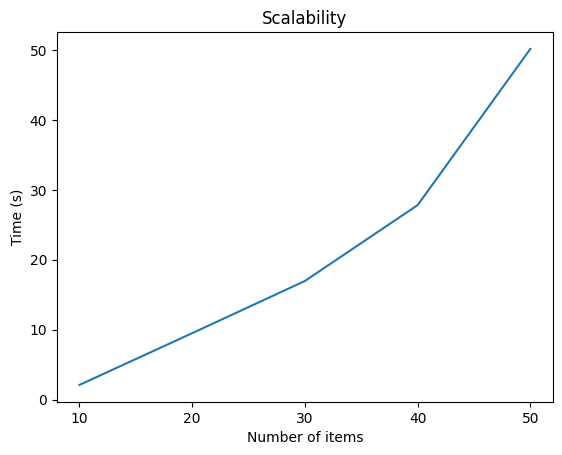

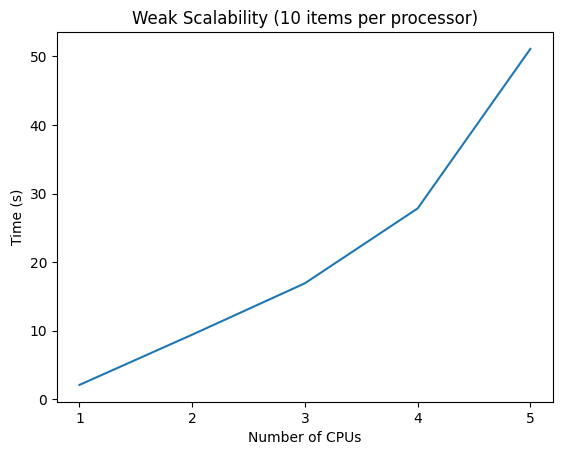

In [ ]:
#cell to generate graphs
import matplotlib.pyplot as plt

#Recorded data from running on google cloud
#the indices are number of cpus - 1
#time_x is time taken for x items
time_10 = [2.103071689605713, 1.9793431758880615, 2.0477850437164307, 1.9715495109558105, 1.967055082321167,  1.938098430633545, 2.0570929050445557, 1.9890098571777344]
time_20 = [9.501717805862427, 9.430088520050049, 9.448616743087769, 9.40314507484436]
time_30 = [16.967140913009644, 16.846158027648926, 16.923189878463745, 16.67768692970276]
time_40 = [27.815152406692505, 27.663728952407837, 27.86471724510193, 27.834558963775635]
time_50 = [50.15087270736694, 48.843552350997925, 50.282888650894165, 49.60892415046692, 51.09210705757141]

#Scalability is time against problem size on 1 CPU
problem_size = [10, 20, 30, 40, 50]
time_scalability = [2.103071689605713, 9.501717805862427, 16.967140913009644, 27.815152406692505, 50.15087270736694]
plt.plot(problem_size, time_scalability)
plt.xticks(problem_size)
plt.title('Scalability')
plt.xlabel('Number of items')
plt.ylabel('Time (s)')
plt.show()

#Weak Scalability is how the solution time varies with the number of processors for a fixed problem size per processor
solution_time = [2.103071689605713, 9.430088520050049, 16.923189878463745, 27.834558963775635, 51.09210705757141]
cpus = [1, 2, 3, 4, 5]
plt.plot(cpus, solution_time)
plt.xticks(cpus)
plt.title('Weak Scalability (10 items per processor)')
plt.xlabel('Number of CPUs')
plt.ylabel('Time (s)')
plt.show()


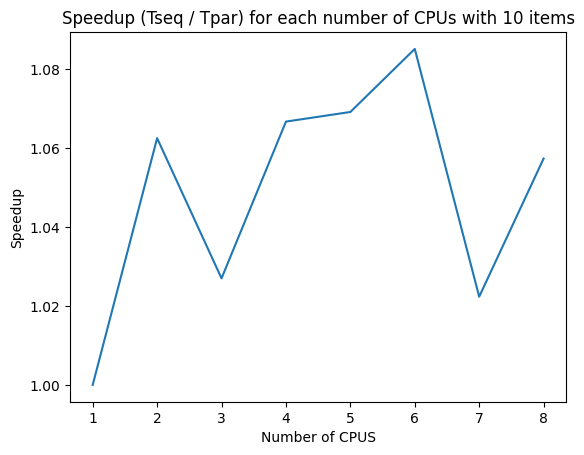

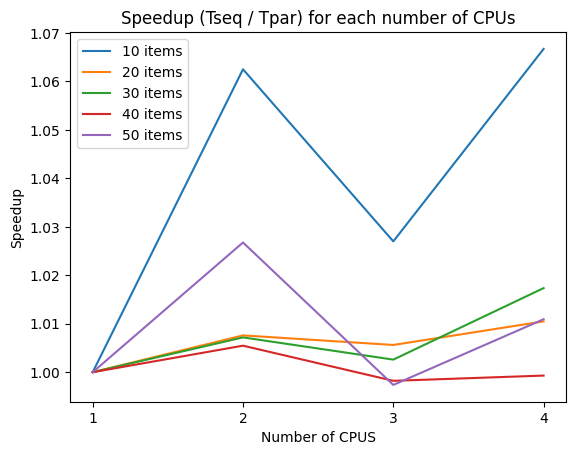

In [ ]:
#cell to generate graphs
# Compute speedup (Tseq / Tpar) for each setting of P, using Tseq = P=1 data point. Create a graph with P on the X-axis and speedup on the Y-axis.
import matplotlib.pyplot as plt

#with 10 items
Tpar = [2.103071689605713, 1.9793431758880615, 2.0477850437164307, 1.9715495109558105, 1.967055082321167,  1.938098430633545, 2.0570929050445557, 1.9890098571777344]
Tseq = 2.103071689605713
P = [1, 2, 3, 4, 5, 6, 7, 8]
speedup = [Tseq/x for x in Tpar]
plt.plot(P, speedup)
plt.title('Speedup (Tseq / Tpar) for each number of CPUs with 10 items')
plt.xlabel('Number of CPUS')
plt.ylabel('Speedup')
plt.show()


#with 10, 20, 30, 40, 50 items but 1-4 CPUS
P = [1, 2, 3, 4]
Tpar_10 = [2.103071689605713, 1.9793431758880615, 2.0477850437164307, 1.9715495109558105]
Tseq_10 = 2.103071689605713
speedup_10 = [Tseq_10/x for x in Tpar_10]

Tpar_20 = [9.501717805862427, 9.430088520050049, 9.448616743087769, 9.40314507484436]
Tseq_20 = 9.501717805862427
speedup_20 = [Tseq_20/x for x in Tpar_20]

Tpar_30 = [16.967140913009644, 16.846158027648926, 16.923189878463745, 16.67768692970276]
Tseq_30 = 16.967140913009644
speedup_30 = [Tseq_30/x for x in Tpar_30]

Tpar_40 = [27.815152406692505, 27.663728952407837, 27.86471724510193, 27.834558963775635]
Tseq_40 = 27.815152406692505
speedup_40 = [Tseq_40/x for x in Tpar_40]

Tpar_50 = [50.15087270736694, 48.843552350997925, 50.282888650894165, 49.60892415046692]
Tseq_50 = 50.15087270736694
speedup_50 = [Tseq_50/x for x in Tpar_50]


plt.plot(P, speedup_10, label='10 items')
plt.plot(P, speedup_20, label='20 items')
plt.plot(P, speedup_30, label='30 items')
plt.plot(P, speedup_40, label='40 items')
plt.plot(P, speedup_50, label='50 items')
plt.legend()
plt.xticks(P)
plt.title('Speedup (Tseq / Tpar) for each number of CPUs')
plt.xlabel('Number of CPUS')
plt.ylabel('Speedup')
plt.show()

In [ ]:
#used for testing
#serpeate into smaller groups for easier processing  by longitude and latitude
def separate_into_smaller_groups_without_clustering(data):
    # Ensure longitude and latitude are rounded and included in the DataFrame
    data['longitude_0dp'] = data['longitude'].round()
    data['latitude_0dp'] = data['latitude'].round()
    data['latitude'] = data['latitude'].astype(float)
    data['longitude'] = data['longitude'].astype(float)

    # Grouping by rounded longitude and latitude
    grouped_df = data.groupby(['longitude_0dp', 'latitude_0dp'])
    return grouped_df

# find common categories across all groups
import ast
import dask.array as da

def find_top_1_rated_categories_in_each_group(grouped_df):
  top_1_in_each = grouped_df.apply(lambda x: x.nlargest(1, 'rating'))
  return top_1_in_each

grouped_df = separate_into_smaller_groups_without_clustering(df_subset)
top_1_in_each = find_top_1_rated_categories_in_each_group(grouped_df)
unique_categories = top_1_in_each['category'].explode().unique()
print(unique_categories)


#Rerunning algorithms for graphs

#get dataframe of smaller sizes for testing and to check scalibility
df_subset = df.head(300);
#df_subset = df.head(3000);
#df_subset = df.head(30000);
#df_subset = df.head(300000);
#df_subset = df.head(3000000);
#df_subset = df.head(30000000);
print(df_subset.columns.tolist())


grouped_df = separate_into_smaller_groups_without_clustering(df_subset)
top_1_in_each = find_top_1_rated_categories_in_each_group(grouped_df)
unique_categories = top_1_in_each['category'].explode().unique()
print(unique_categories)